In [1]:
# 1. wisdm dataset(sitting 4500, running 4500)
# 3. sitting train, sitting + running test

In [2]:
# 필요한 라이브러리 로드
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [3]:
names = ['user-id', 'activity', 'timestamp', 'X', 'Y', 'Z']

df = pd.read_csv('D:/Son/3-2/deeplearning/report/dataset/WISDM/WISDM.csv', index_col=0)

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df["Z"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["Z"] = df["Z"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.info()

C:\Users\gudrh\AppData\Local\Temp\ipykernel_19248\2062605742.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user-id    1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   X          1098203 non-null  float64
 4   Y          1098203 non-null  float64
 5   Z          1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


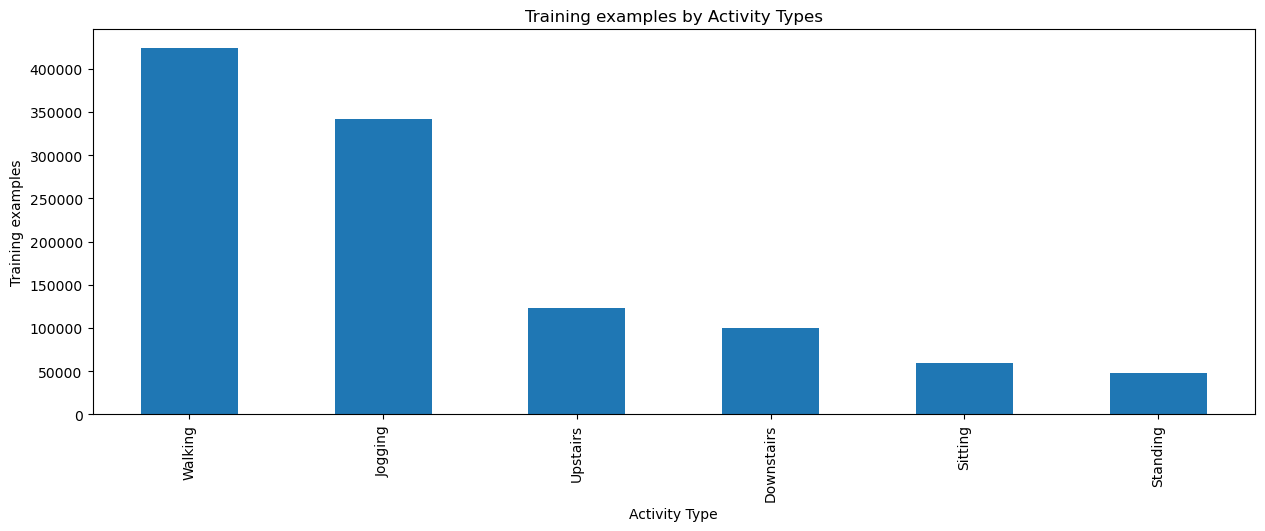

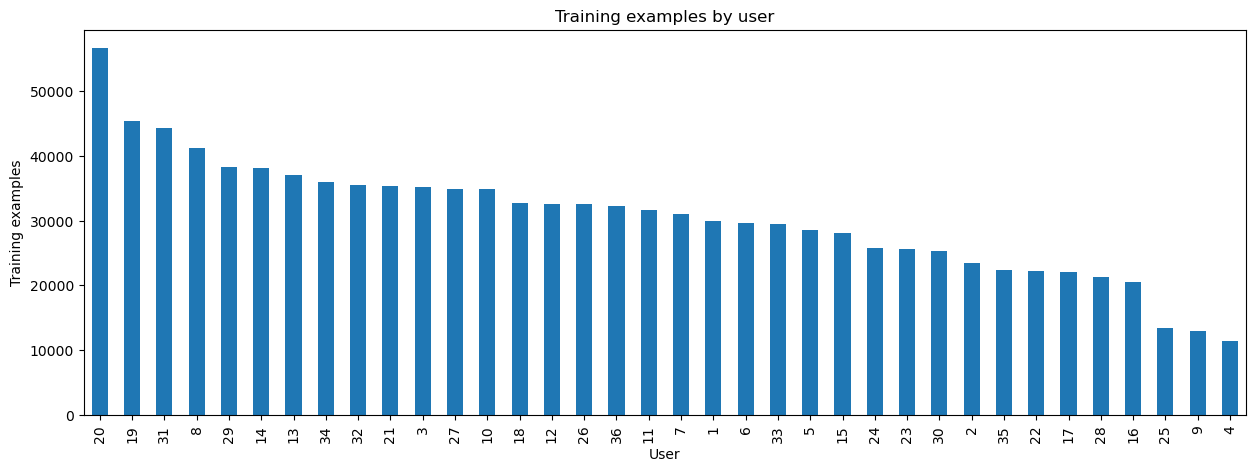

In [4]:
plt.figure(figsize=(15, 5))

plt.xlabel('Activity Type')
plt.ylabel('Training examples')
df['activity'].value_counts().plot(kind='bar',
                                  title='Training examples by Activity Types')
plt.show()

plt.figure(figsize=(15, 5))
plt.xlabel('User')
plt.ylabel('Training examples')
df['user-id'].value_counts().plot(kind='bar', 
                                 title='Training examples by user')
plt.show()

In [5]:
df_sit = df[df['activity'] == 'Sitting']
df_run = df[df['activity'] == 'Jogging']

In [6]:
df_run

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1080754,19,Jogging,130447441469000,-7.010000,-10.530000,0.570000
1080755,19,Jogging,130447481508000,-6.360000,-3.910000,-0.420000
1080756,19,Jogging,130447521547000,-11.260000,3.020000,1.570000
1080757,19,Jogging,130447561678000,-17.540000,4.670000,3.980000


In [7]:
df_sit_sample = df_sit.head(4500).copy()

In [8]:
df_sit_sample

,user-id,activity,timestamp,X,Y,Z
221333,27,Sitting,12363992261000,2.60,9.66,1.035146
221334,27,Sitting,12364042279000,2.68,9.53,0.503953
221335,27,Sitting,12364092267000,3.49,8.89,0.762740
221336,27,Sitting,12364142316000,3.64,9.38,0.926184
221337,27,Sitting,12364192273000,2.91,9.34,1.035146
...,...,...,...,...,...,...
255294,36,Sitting,14927622266000,-4.33,-2.18,8.308413
255295,36,Sitting,14927672254000,-4.37,-2.22,8.349273
255296,36,Sitting,14927722272000,-4.29,-2.22,8.308413
255297,36,Sitting,14927772199000,-4.29,-2.22,8.281172


In [9]:
df_run_sample = df_run.head(4500).copy()

In [10]:
df_run_sample

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
13015,17,Jogging,58401032305000,5.434519,8.853226,3.909040
13016,17,Jogging,58401203050000,-4.331271,19.531578,-1.729784
13017,17,Jogging,58401432238000,-1.035146,-5.012288,-4.481094
13018,17,Jogging,58401542223000,7.082581,17.243360,-0.381370


In [11]:
data = pd.concat([df_sit_sample, df_run_sample])

In [12]:
data

,user-id,activity,timestamp,X,Y,Z
221333,27,Sitting,12363992261000,2.600000,9.660000,1.035146
221334,27,Sitting,12364042279000,2.680000,9.530000,0.503953
221335,27,Sitting,12364092267000,3.490000,8.890000,0.762740
221336,27,Sitting,12364142316000,3.640000,9.380000,0.926184
221337,27,Sitting,12364192273000,2.910000,9.340000,1.035146
...,...,...,...,...,...,...
13015,17,Jogging,58401032305000,5.434519,8.853226,3.909040
13016,17,Jogging,58401203050000,-4.331271,19.531578,-1.729784
13017,17,Jogging,58401432238000,-1.035146,-5.012288,-4.481094
13018,17,Jogging,58401542223000,7.082581,17.243360,-0.381370


In [13]:
data = data.drop(['user-id','timestamp'], axis = 1)

In [14]:
data

,activity,X,Y,Z
221333,Sitting,2.600000,9.660000,1.035146
221334,Sitting,2.680000,9.530000,0.503953
221335,Sitting,3.490000,8.890000,0.762740
221336,Sitting,3.640000,9.380000,0.926184
221337,Sitting,2.910000,9.340000,1.035146
...,...,...,...,...
13015,Jogging,5.434519,8.853226,3.909040
13016,Jogging,-4.331271,19.531578,-1.729784
13017,Jogging,-1.035146,-5.012288,-4.481094
13018,Jogging,7.082581,17.243360,-0.381370


In [15]:
from sklearn.preprocessing import LabelEncoder



le=LabelEncoder()

data['activity']=le.fit_transform(data['activity'])

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9000 entries, 221333 to 13019
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   activity  9000 non-null   int32  
 1   X         9000 non-null   float64
 2   Y         9000 non-null   float64
 3   Z         9000 non-null   float64
dtypes: float64(3), int32(1)
memory usage: 316.4 KB


In [17]:
df_train, df_test = train_test_split(data, test_size=0.25, random_state=1)

In [18]:
df_train = df_train[df_train['activity']==0]

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3365 entries, 8048 to 5656
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   activity  3365 non-null   int32  
 1   X         3365 non-null   float64
 2   Y         3365 non-null   float64
 3   Z         3365 non-null   float64
dtypes: float64(3), int32(1)
memory usage: 118.3 KB


In [20]:
x_train = df_train.drop(['activity'], axis=1)

In [21]:
x_train

,X,Y,Z
8048,3.786457,14.900661,5.284695
5637,-8.580819,13.375181,3.636633
7964,-2.792171,8.621680,4.671779
6937,-1.797886,11.032481,6.660350
6047,1.225831,16.698545,12.408136
...,...,...,...
5860,-11.073342,19.572440,0.272407
11771,-2.410802,3.377846,-5.625204
556,-5.666065,19.422615,9.575105
11833,9.003050,8.921328,-2.751310


In [22]:
y_test = df_test['activity']
x_test = df_test.drop(['activity'],axis=1)

In [23]:
y_test

5685      0
253774    1
6829      0
12611     0
222654    1
         ..
254666    1
253910    1
223142    1
8345      0
253319    1
Name: activity, Length: 2250, dtype: int32

In [24]:
x_test

,X,Y,Z
5685,6.510526,14.328606,8.471856
253774,-4.790000,-2.260000,7.927042
6829,6.932757,17.311462,-3.064578
12611,10.501288,16.698545,1.838747
222654,3.340000,9.300000,1.076008
...,...,...,...
254666,-4.290000,-2.260000,8.199450
253910,-4.560000,-2.070000,8.199450
223142,3.170000,9.300000,1.116869
8345,-5.012288,11.182305,5.475380


In [25]:
noise_factor = 0.50

x_train_noisy = x_train.copy() + noise_factor * \
np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)

x_test_noisy = x_test.copy() + noise_factor * \
np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

In [26]:
input_dim = x_train.shape[1]
encoding_dim = 20
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim/2, activation="relu", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim/2 ), activation='relu')(encoder)
encoder = Dense(int(encoding_dim/4 ), activation='relu')(encoder)
encoder = Dense(int(encoding_dim / 6), activation='linear')(encoder)
decoder = Dense(int(encoding_dim/4 ), activation='relu')(encoder)
decoder = Dense(int(encoding_dim/2 ), activation='relu')(decoder)
decoder = Dense(int(encoding_dim/2 ), activation='relu')(decoder)
decoder = Dense(input_dim, activation='linear')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [27]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 10)                40        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
 dense_3 (Dense)             (None, 3)                 18        
                                                                 
 dense_4 (Dense)             (None, 5)                 20        
                                                                 
 dense_5 (Dense)             (None, 10)                60    

In [28]:
#nb_epoch = 100
nb_epoch = 20
batch_size = 16
autoencoder.compile(optimizer='Adam', 
                    loss='mean_squared_error',
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(x_train_noisy,x_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data = (x_train_noisy, x_train),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/20
211/211 [==============================] - 2s 5ms/step - loss: 34.1785 - accuracy: 0.6401 - val_loss: 18.4937 - val_accuracy: 0.6871
Epoch 2/20
211/211 [==============================] - 1s 3ms/step - loss: 16.8425 - accuracy: 0.7019 - val_loss: 16.0667 - val_accuracy: 0.7296
Epoch 3/20
211/211 [==============================] - 1s 3ms/step - loss: 15.9916 - accuracy: 0.7319 - val_loss: 15.8885 - val_accuracy: 0.7379
Epoch 4/20
211/211 [==============================] - 1s 3ms/step - loss: 15.7781 - accuracy: 0.7438 - val_loss: 15.6860 - val_accuracy: 0.7527
Epoch 5/20
211/211 [==============================] - 1s 3ms/step - loss: 15.6193 - accuracy: 0.7533 - val_loss: 15.5001 - val_accuracy: 0.7563
Epoch 6/20
211/211 [==============================] - 1s 3ms/step - loss: 13.7736 - accuracy: 0.7593 - val_loss: 8.1525 - val_accuracy: 0.7632
Epoch 7/20
211/211 [==============================] - 1s 3ms/step - loss: 6.7908 - accuracy: 0.7605 - val_loss: 6.1395 - val_accuracy: 0.

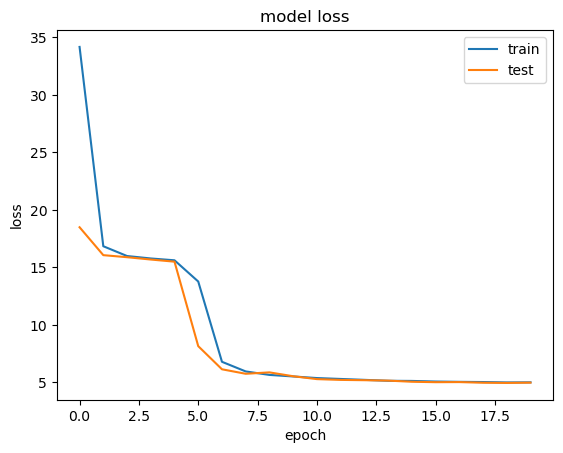

In [29]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [30]:
predictions = autoencoder.predict(x_test_noisy)
mse = np.mean(np.power(x_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

71/71 [==============================] - 0s 895us/step


,reconstruction_error,true_class
count,2250.000000,2250.000000
mean,9.462561,0.495556
std,11.290800,0.500091
min,0.001984,0.000000
25%,0.325480,0.000000
50%,2.675839,0.000000
75%,24.722572,1.000000
max,70.865222,1.000000


In [31]:
error_df.true_class.value_counts()

0    1135
1    1115
Name: true_class, dtype: int64

In [32]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

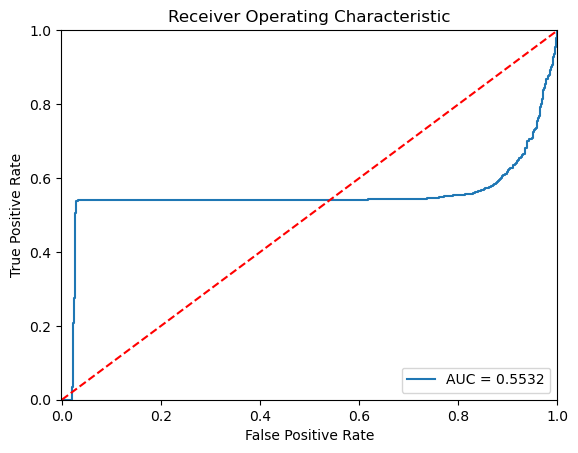

In [33]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

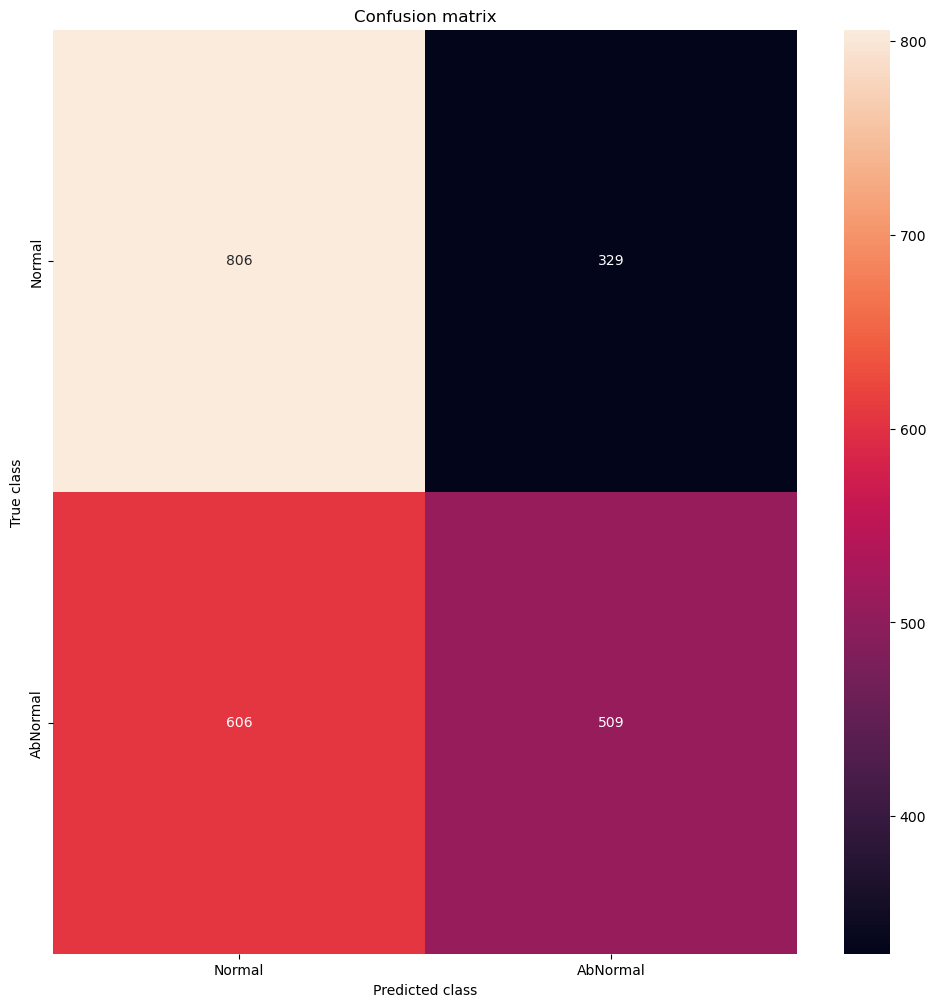

In [34]:
#평가관련
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import seaborn as sns

LABELS = ["Normal", "AbNormal"]
threshold = 1


y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]

conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");

plt.title("Confusion matrix")

plt.ylabel('True class')

plt.xlabel('Predicted class')

plt.show()

In [35]:
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')

print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )

print ('Precision :',precision )

print ('Recall :',recall )

print ('F1 :',f1 )

Accuracy Score : 0.5844444444444444
Precision : 0.6073985680190931
Recall : 0.4565022421524664
F1 : 0.5212493599590373
